### X lines of Python
# Gridding map data

I'm using a small dataset originally from [**Geoff Bohling**](http://people.ku.edu/~gbohling/) at the Kansas Geological Survey. I can no longer find the data online.

## Load and inspect the data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

We'll load the data from the web; if you are offline but have the repo, the data file is also in `../data/ZoneA.dat`. 

In [3]:
# Essential line number 1.
df = pd.read_csv('https://www.dropbox.com/s/6dyfc4fl5slhgry/ZoneA.dat?raw=1',
                 sep=' ',
                 header=9,
                 usecols=[0, 1, 2, 3],
                 names=['x', 'y', 'thick', 'por']
                )

In [4]:
df.head()

,x,y,thick,por
0,12100,8300,37.1531,14.6515
1,5300,8700,31.4993,14.5093
2,3500,13900,36.9185,14.0639
3,5100,1900,24.0156,15.1084
4,9900,13700,35.0411,13.9190


In [5]:
df.describe()

,x,y,thick,por
count,85.000000,85.000000,85.000000,85.000000
mean,9460.000000,7561.176471,34.122658,14.695880
std,5522.059657,4467.983835,4.150109,0.887037
min,100.000000,100.000000,24.015600,12.149100
25%,4700.000000,3700.000000,31.499300,14.133300
50%,9100.000000,7100.000000,33.921700,14.651500
75%,14100.000000,11300.000000,37.541500,15.260600
max,19500.000000,15700.000000,43.821700,16.958300


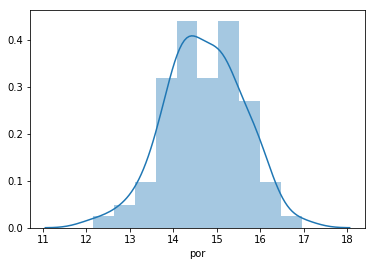

In [6]:
sns.distplot(df.por)

This looks a bit unpleasant, but we're just getting out min and max values for the x and y columns.

In [7]:
# Line 2.
extent = x_min, x_max, y_min, y_max = [df.x.min()-1000, df.x.max()+1000, df.y.min()-1000, df.y.max()+1000]

Now we can plot the data:

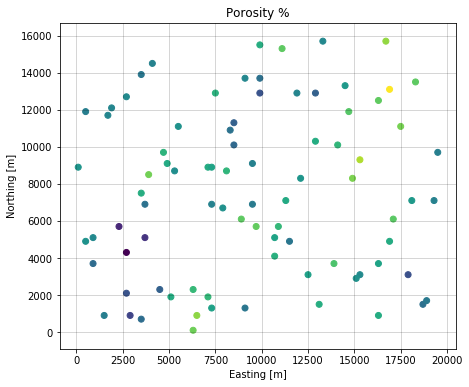

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(df.x, df.y, c=df.por)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Porosity %')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a regular grid

Following [this recipe](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf)

We must make a grid, which represents the points we'd like to predict.

In [9]:
# Line 3.
grid_x, grid_y = np.mgrid[x_min:x_max:500, y_min:y_max:500]

# Use imaginary numbers for the step to specify the *number* (not size) of bins:
# grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

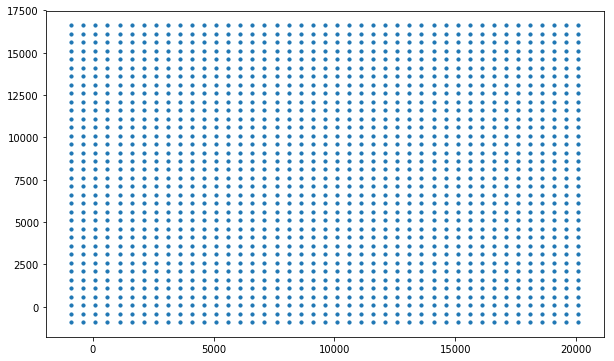

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(grid_x, grid_y, s=10)

That was easy!

## Interpolation with radial basis function

Now we make an interpolator and use it to predict into the grid 'cells'.

In [11]:
from scipy.interpolate import Rbf

# Make an n-dimensional interpolator. This is essential line number 4.
rbfi = Rbf(df.x, df.y, df.por)

# Predict on the regular grid. Line 5.
di = rbfi(grid_x, grid_y)

Let's plot the result. First, we'll need the min and max of the combined sparse and gridded data, so we can plot them with the same colourmap ranges:

In [12]:
mi = np.min(np.hstack([di.ravel(), df.por.values]))
ma = np.max(np.hstack([di.ravel(), df.por.values]))

Notice the transpose and the `origin='lower'`, to keep everything matched up with the original dataset.

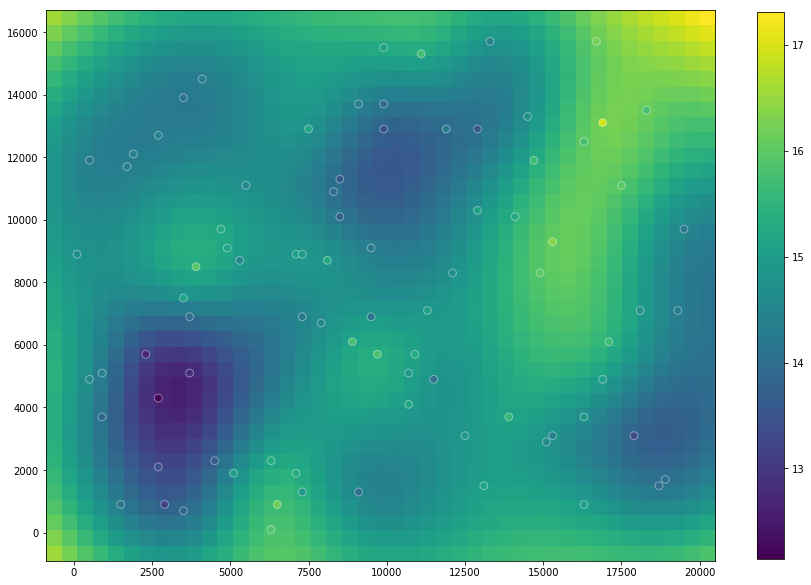

In [17]:
plt.figure(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=mi, vmax=ma)
c2 = plt.scatter(df.x, df.y, s=60, c=df.por, edgecolor='#ffffff66', vmin=mi, vmax=ma)

plt.colorbar(c1, shrink=0.67)
plt.show()

The circles (the data) are the same colour as the grid (the model), so we can see that the error on this prediction is almost zero. In fact, the default parameters force the model to pass through all the data points (interpolation, as opposed to estimation or approximation).

The `Rbf()` interpolator has [a few options](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html). The most important one is probably `smooth`, which is the thing to increase if you end up with a singular matrix (because it can't converge on a solution). Anything above 0 relaxes the constraint that the surface must pass through every point. If you get an error, you probably need to change the smoothing.

You can also change the `function` (default is `multiquadric`, which also has an `epsilon` parameter to vary the range of influence of each point).

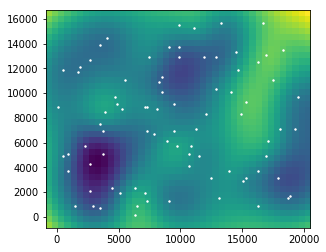

In [14]:
rbfi = Rbf(df.x, df.y, df.por, smooth=0.2)
di = rbfi(grid_x, grid_y)

plt.imshow(di.T, origin="lower", extent=extent)
plt.scatter(df.x, df.y, s=2, c='w')
plt.show()

We can also make a histogram and kernel density estimation of the errors, by making predictions at the original input locations:

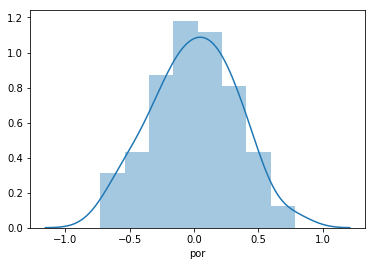

In [15]:
por_hat = rbfi(df.x, df.y)

sns.distplot(por_hat - df.por)

With the smoothing set to 0.2, we end up with a smoother surface, but pay for it with larger errors.

## Interpolation with `scipy.griddata()`

The `Rbf()` interpolator is the one to know about, because it has lots of useful parameters. It's probably the only one you need to know. But there is also `scipy.griddata()`. For example see [this SciPy recipe](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.griddata.html).

The interface is slightly different &mdash; we have to pass a single array of the coordinates (the (x, y) locations of the points we know). We also pass the values to interpolate, and the grids.

The function will not accept Pandas `Series` objects, so we'll use the `Series.values` attribute to get at the NumPy array representation.

First, let's make the 2D array of coordinates:

In [15]:
points = df[['x', 'y']].values

The grdding step is easy. We'll try three different algorithms:

In [16]:
from scipy.interpolate import griddata

grid_z0 = griddata(points, df.por.values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, df.por.values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, df.por.values, (grid_x, grid_y), method='cubic')

Inspect the results.

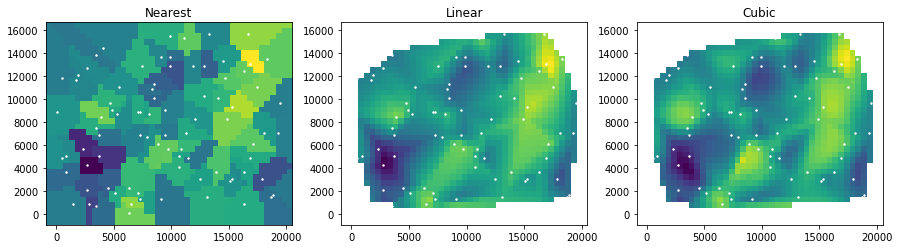

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0.T, origin='lower', extent=extent)
ax.scatter(df.x, df.y, s=2, c='w')
ax.set_title('Nearest')

ax = axs[1]
ax.imshow(grid_z1.T, origin='lower', extent=extent)
ax.scatter(df.x, df.y, s=2, c='w')
ax.set_title('Linear')

ax = axs[2]
ax.imshow(grid_z2.T, origin='lower', extent=extent)
ax.scatter(df.x, df.y, s=2, c='w')
ax.set_title('Cubic')

plt.show()

I don't particularly like any of these results.

## Using `sklearn.gaussian_process`

Modeling with a Gaussian process is equivalent to kriging. Conveniently, the popular machine learning library `scikit-learn` has a Gaussian process modeling tool.

In [18]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

The main hyperparameters are the kernel, which we just defined, and `alpha`, which controls the smoothness. Larger values imply mmore noise in the input data, and result in smoother grids; default is very small: 1 &times; 10<sup>-9</sup>.

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.1,  # Larger values imply more noise in the input data.
                              kernel=kernel,)

gp.fit(df[['x', 'y']].values, df.por.values)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
             kernel=RBF(length_scale=1e+03), n_restarts_optimizer=0,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

To make a prediction, we need to construct the X matrix: (x, y) coordinates in 2 columns:

In [20]:
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

Now we can make a prediction:

In [21]:
y_grid = gp.predict(X_grid).reshape(grid_x.shape)

And plot the predicted grid with the input data using the same colourmap:

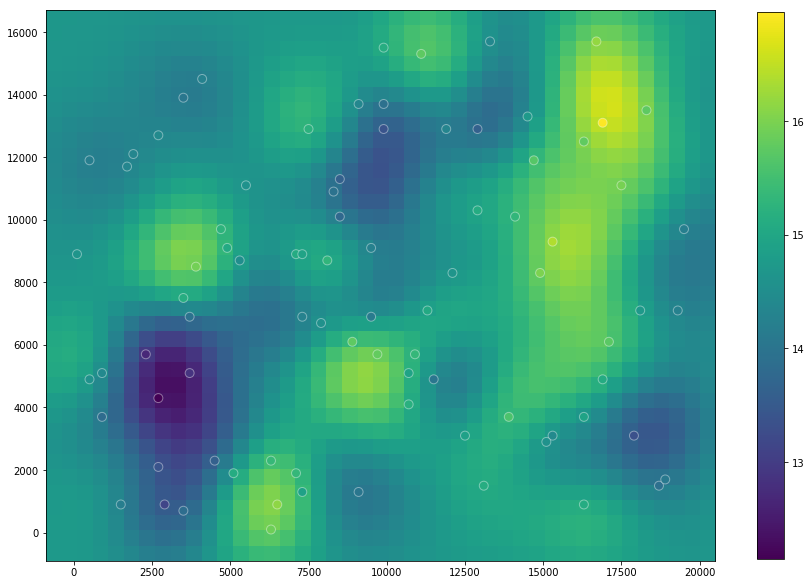

In [22]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(y_grid.T, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

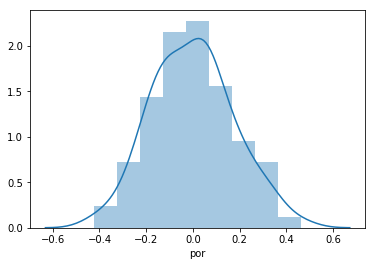

In [23]:
por_hat = gp.predict(df[['x', 'y']].values)

sns.distplot(por_hat - df.por)

## Just the essential bits

This is the minimal code required to load the data and make a model.

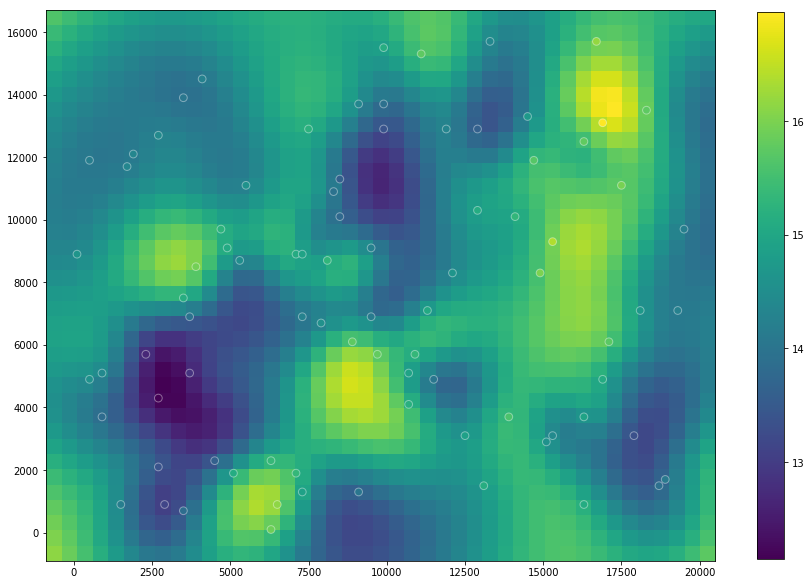

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# Load the data.
df = pd.read_csv('../data/ZoneA.dat',
                 sep=' ',
                 header=9,
                 usecols=[0, 1, 2, 3],
                 names=['x', 'y', 'thick', 'por']
                )

# Build a regular grid with 500-metre cells.
extent = x_min, x_max, y_min, y_max = [df.x.min()-1000, df.x.max()+1000,
                                       df.y.min()-1000, df.y.max()+1000]
grid_x, grid_y = np.mgrid[x_min:x_max:500, y_min:y_max:500]

# Make the interpolator and do the interpolation.
rbfi = Rbf(df.x, df.y, df.por)
di = rbfi(grid_x, grid_y)

# Make the plot.
plt.figure(figsize=(15,15))
plt.imshow(di.T, origin="lower", extent=extent)
cb = plt.scatter(df.x, df.y, s=60, c=df.por, edgecolor='#ffffff66')
plt.colorbar(cb, shrink=0.67)
plt.show()

----

&copy; 2019 Agile Scientific, licensed CC-BY